In [1]:
%matplotlib inline

import pandas
import statistics
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

# bug fix for display formats to avoid run time errors
pandas.set_option('display.float_format', lambda x:'%.2f'%x)

#load the data
data = pandas.read_csv('../separatedData.csv')

# convert to numeric format
data["breastCancer100th"] = pandas.to_numeric(data["breastCancer100th"], errors='coerce')
data["meanSugarPerson"]   = pandas.to_numeric(data["meanSugarPerson"], errors='coerce')
data["meanFoodPerson"]   = pandas.to_numeric(data["meanFoodPerson"], errors='coerce')
data["meanCholesterol"]   = pandas.to_numeric(data["meanCholesterol"], errors='coerce')

# listwise deletion of missing values
sub1 = data[['breastCancer100th', 'meanFoodPerson', 'meanCholesterol', 'meanSugarPerson']].dropna()

#Split into training and testing sets
cluster = sub1[[ 'meanSugarPerson', 'meanFoodPerson', 'meanCholesterol']]

# standardize predictors to have mean=0 and sd=1
clustervar = cluster.copy()
clustervar['meanSugarPerson']=preprocessing.scale(clustervar['meanSugarPerson'].astype('float64'))
clustervar['meanFoodPerson']=preprocessing.scale(clustervar['meanFoodPerson'].astype('float64'))
clustervar['meanCholesterol']=preprocessing.scale(clustervar['meanCholesterol'].astype('float64'))

# split data into train and test sets - Train = 70%, Test = 30%
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

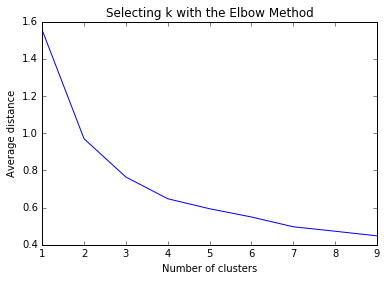

In [2]:
# k-means cluster analysis for 1-9 clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1))
    / clus_train.shape[0])

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

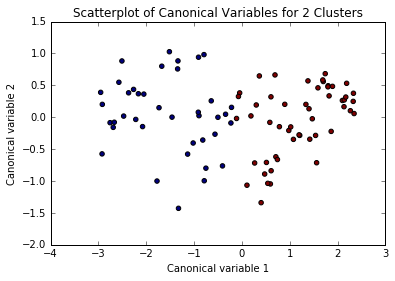

In [3]:
# Interpret 2 cluster solution
model2=KMeans(n_clusters=2)
model2.fit(clus_train)
clusassign=model2.predict(clus_train)
# plot clusters

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model2.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

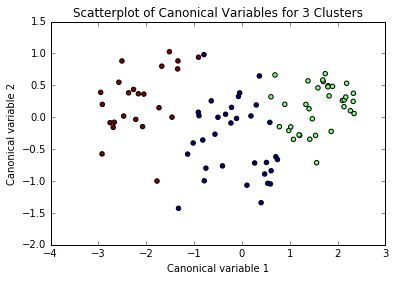

In [4]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)
# plot clusters

from sklearn.decomposition import PCA
pca_3 = PCA(2)
plot_columns = pca_3.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [5]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)

# create a list that has the new index variable
cluslist=list(clus_train['index'])

# create a list of cluster assignments
labels=list(model3.labels_)

# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))

# convert newlist dictionary to a dataframe
newclus=pandas.DataFrame.from_dict(newlist, orient='index')

# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the
# cluster assignment dataframe
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pandas.merge(clus_train, newclus, on='index')
merged_train.head(n=100)

# cluster frequencies
merged_train.cluster.value_counts()

"""
END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)


Clustering variable means by cluster
         index  meanSugarPerson  meanFoodPerson  meanCholesterol
cluster                                                         
0        63.97             0.33           -0.03            -0.08
1        70.82            -1.08           -0.88            -0.90
2        63.26             0.91            1.39             1.33


In [6]:


# validate clusters in training data by examining cluster differences in incidence of cancer using ANOVA
# first have to merge incidence of cancer with clustering variables and cluster assignment data
ic_data=data['breastCancer100th']

# split incidence of cancer data into train and test sets
ic_data, ic_test = train_test_split(ic_data, test_size=.3, random_state=123)
ic_data1=pandas.DataFrame(ic_data)
ic_data1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ic_data1, merged_train, on='index')
sub1 = merged_train_all[['breastCancer100th', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

icmod = smf.ols(formula='breastCancer100th ~ C(cluster)', data=sub1).fit()
print (icmod.summary())

print ('means for breastCancer100th by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('standard deviations for breastCancer100th by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

mc1 = multi.MultiComparison(sub1['breastCancer100th'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())


                            OLS Regression Results                            
Dep. Variable:      breastCancer100th   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sat, 29 Oct 2016   Prob (F-statistic):           1.91e-23
Time:                        01:38:45   Log-Likelihood:                -360.92
No. Observations:                  90   AIC:                             727.8
Df Residuals:                      87   BIC:                             735.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          32.4697      2.363     